(bart_heteroscedasticity)=
# Modeling Heteroscedasticity with BART

:::{post} January, 2023
:tags: BART, regression
:category: beginner, reference
:author: Juan Orduz
:::

In this notebook we show how to use BART to model heteroscedasticity as described in Section 4.1 of [`pymc-bart`](https://github.com/pymc-devs/pymc-bart)'s paper {cite:p}`quiroga2022bart`. We use the `marketing` data set provided by the R package `datarium` {cite:p}`kassambara2019datarium`. The idea is to model a marketing channel contribution to sales as a function of budget.

In [1]:
import os

import arviz.preview as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

In [2]:
%config InlineBackend.figure_format = "retina"
az.style.use("arviz-variat")
plt.rcParams["figure.figsize"] = [10, 6]
rng = np.random.default_rng(42)

## Read Data

In [3]:
try:
    df = pd.read_csv(os.path.join("..", "data", "marketing.csv"), sep=";", decimal=",")
except FileNotFoundError:
    df = pd.read_csv(pm.get_data("marketing.csv"), sep=";", decimal=",")

n_obs = df.shape[0]

df.head()

,youtube,facebook,newspaper,sales
0,276.12,45.36,83.04,26.52
1,53.40,47.16,54.12,12.48
2,20.64,55.08,83.16,11.16
3,181.80,49.56,70.20,22.20
4,216.96,12.96,70.08,15.48


## EDA

We start by looking into the data. We are going to focus on *Youtube*.

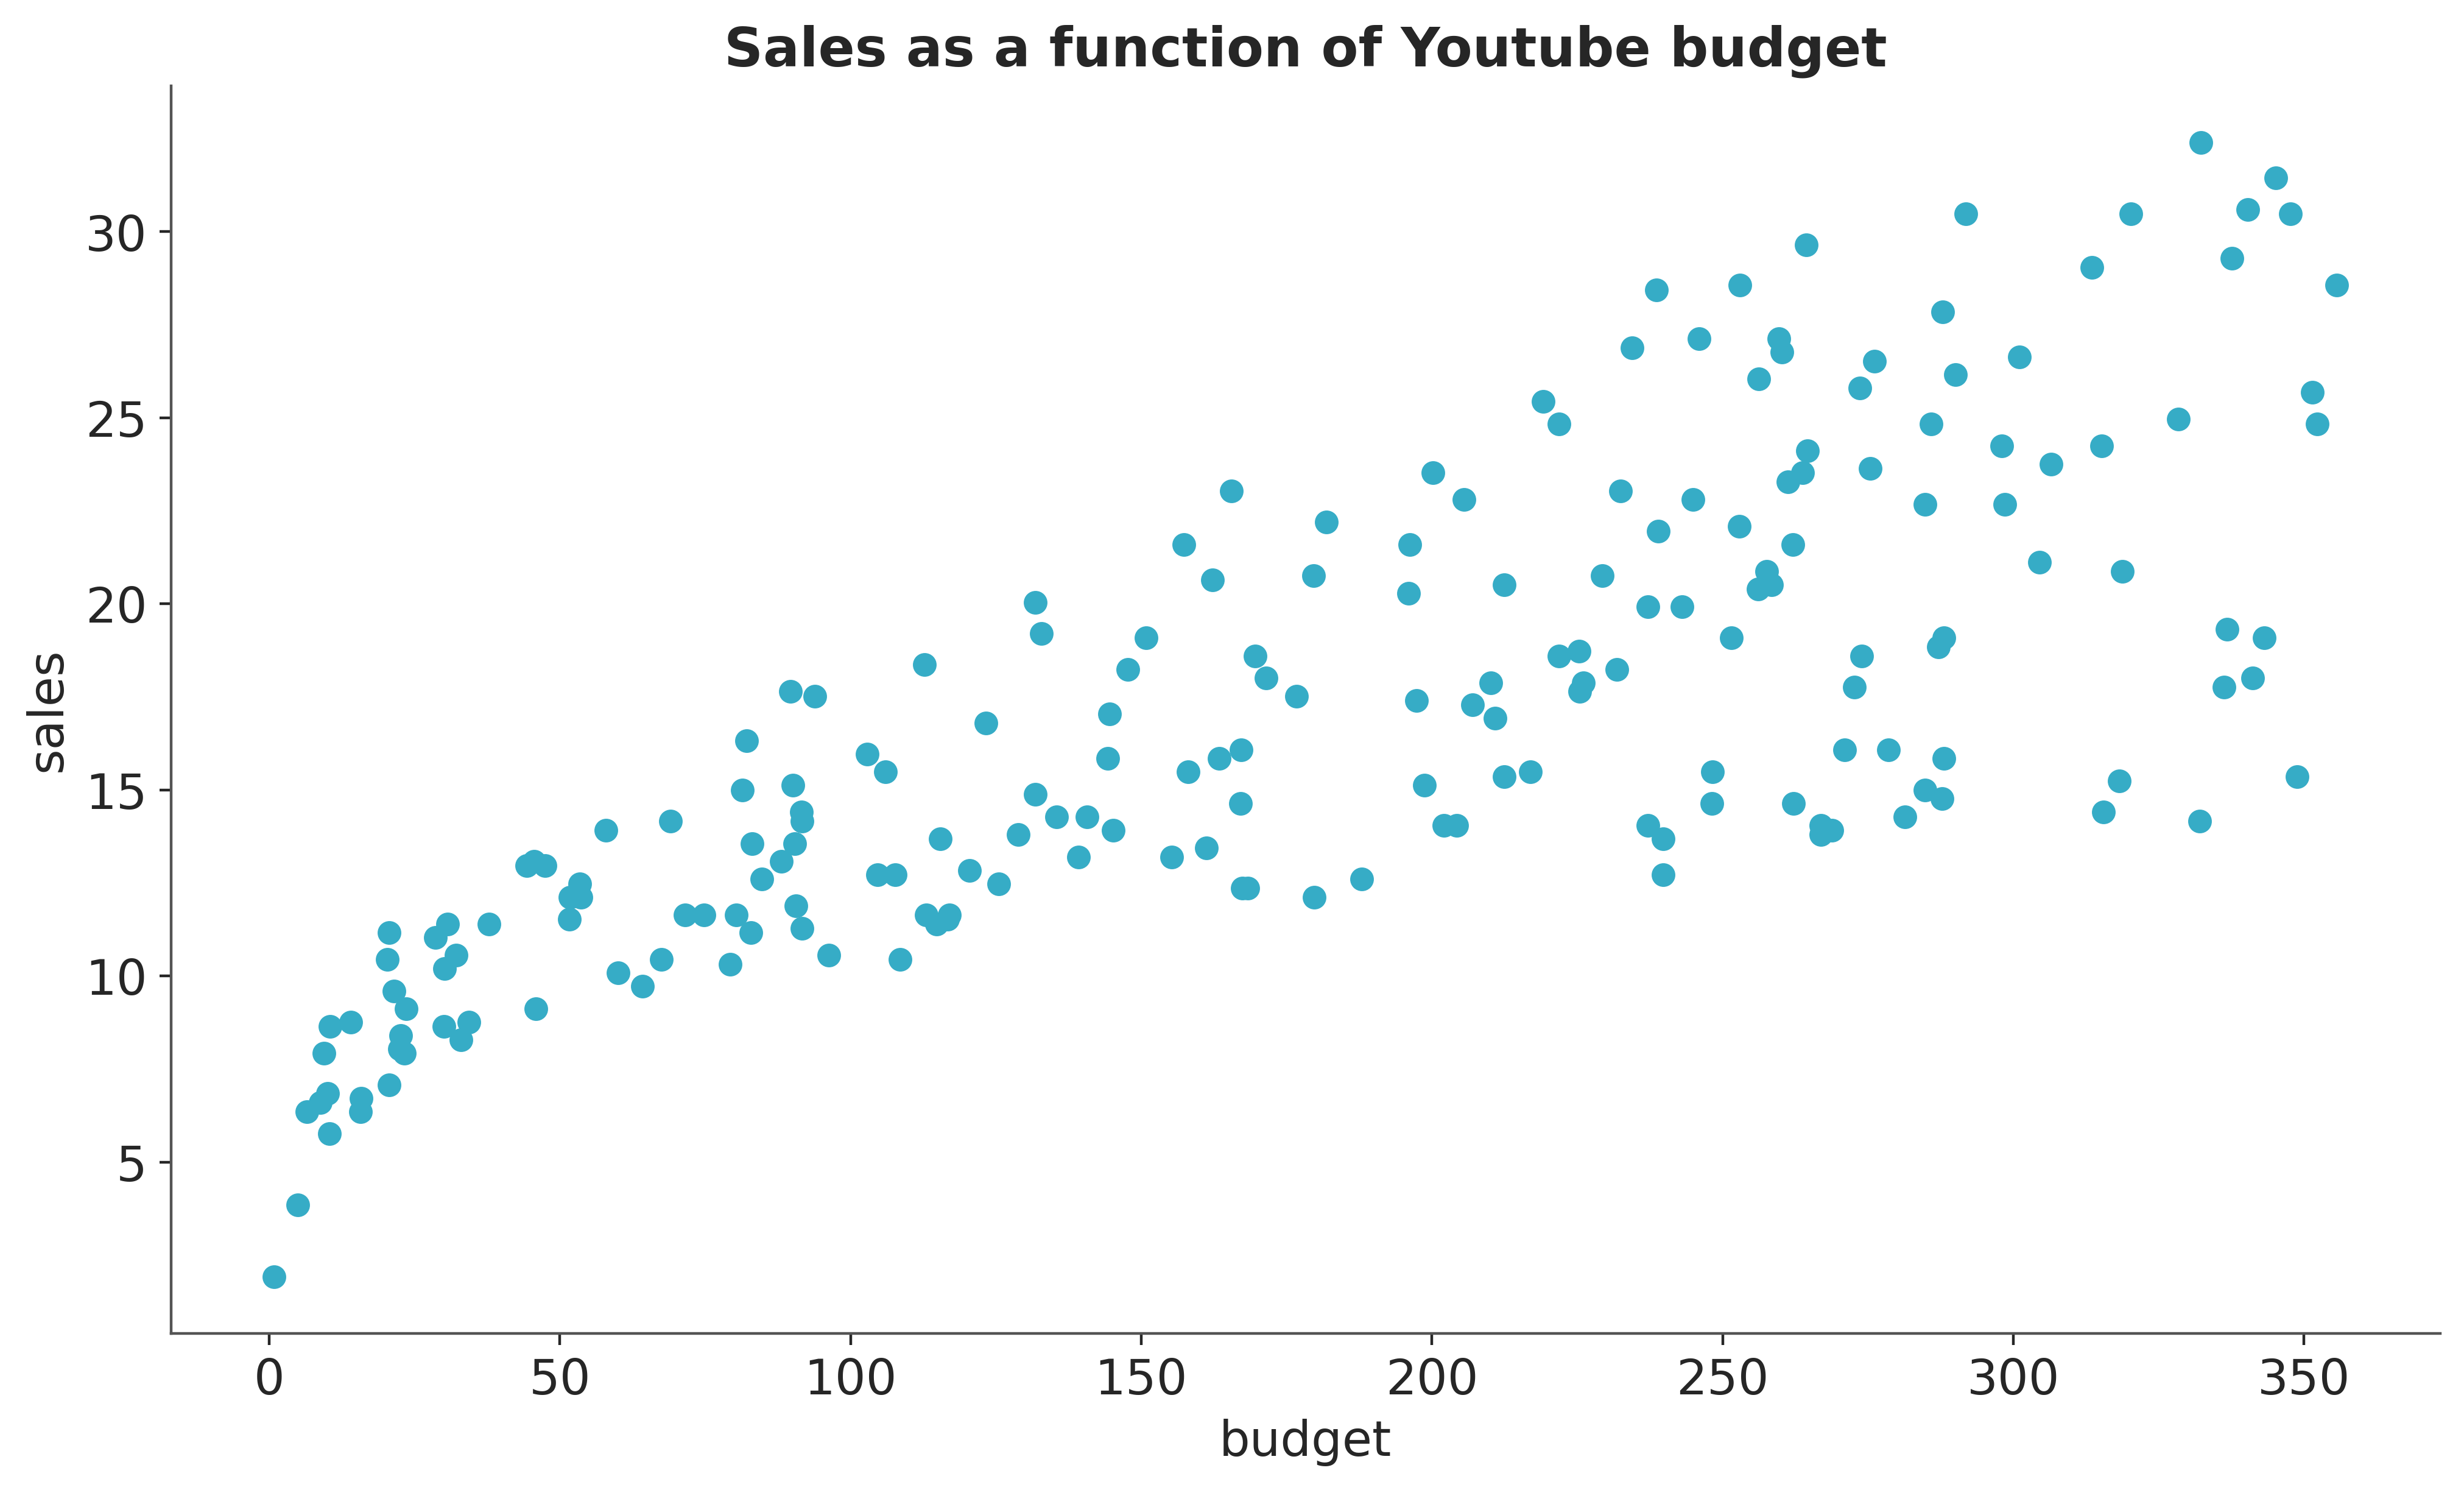

In [4]:
fig, ax = plt.subplots()
ax.plot(df["youtube"], df["sales"], "o", c="C0")
ax.set(title="Sales as a function of Youtube budget", xlabel="budget", ylabel="sales");

We clearly see that both the mean and variance are increasing as a function of budget. One possibility is to manually select an explicit parametrization of these functions, e.g. square root or logarithm. However, in this example we want to learn these functions from the data using a BART model.

## Model Specification

We proceed to prepare the data for modeling. We are going to use the `budget` as the predictor and `sales` as the response.

In [5]:
X = df["youtube"].to_numpy().reshape(-1, 1)
Y = df["sales"].to_numpy()

Next, we specify the model. Note that we just need one BART distribution which can be vectorized to model both the mean and variance. We use a Gamma distribution as likelihood as we expect the sales to be positive.

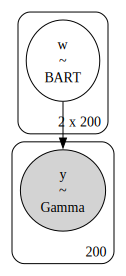

In [6]:
with pm.Model() as model_marketing_full:
    w = pmb.BART("w", X=X, Y=np.log(Y), m=100, shape=(2, n_obs))
    y = pm.Gamma("y", mu=pm.math.exp(w[0]), sigma=pm.math.exp(w[1]), observed=Y)

pm.model_to_graphviz(model=model_marketing_full)

We now fit the model.

In [7]:
with model_marketing_full:
    idata_marketing_full = pm.sample(2000, random_seed=rng, compute_convergence_checks=False)
    posterior_predictive_marketing_full = pm.sample_posterior_predictive(
        trace=idata_marketing_full, random_seed=rng
    )

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [w]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 142 seconds.
Sampling: [y]


Output()

## Results

We can now visualize the posterior predictive distribution of the mean and the likelihood.

In [8]:
posterior_predictive_marketing_full

Inference data with groups:
	> posterior_predictive
	> observed_data

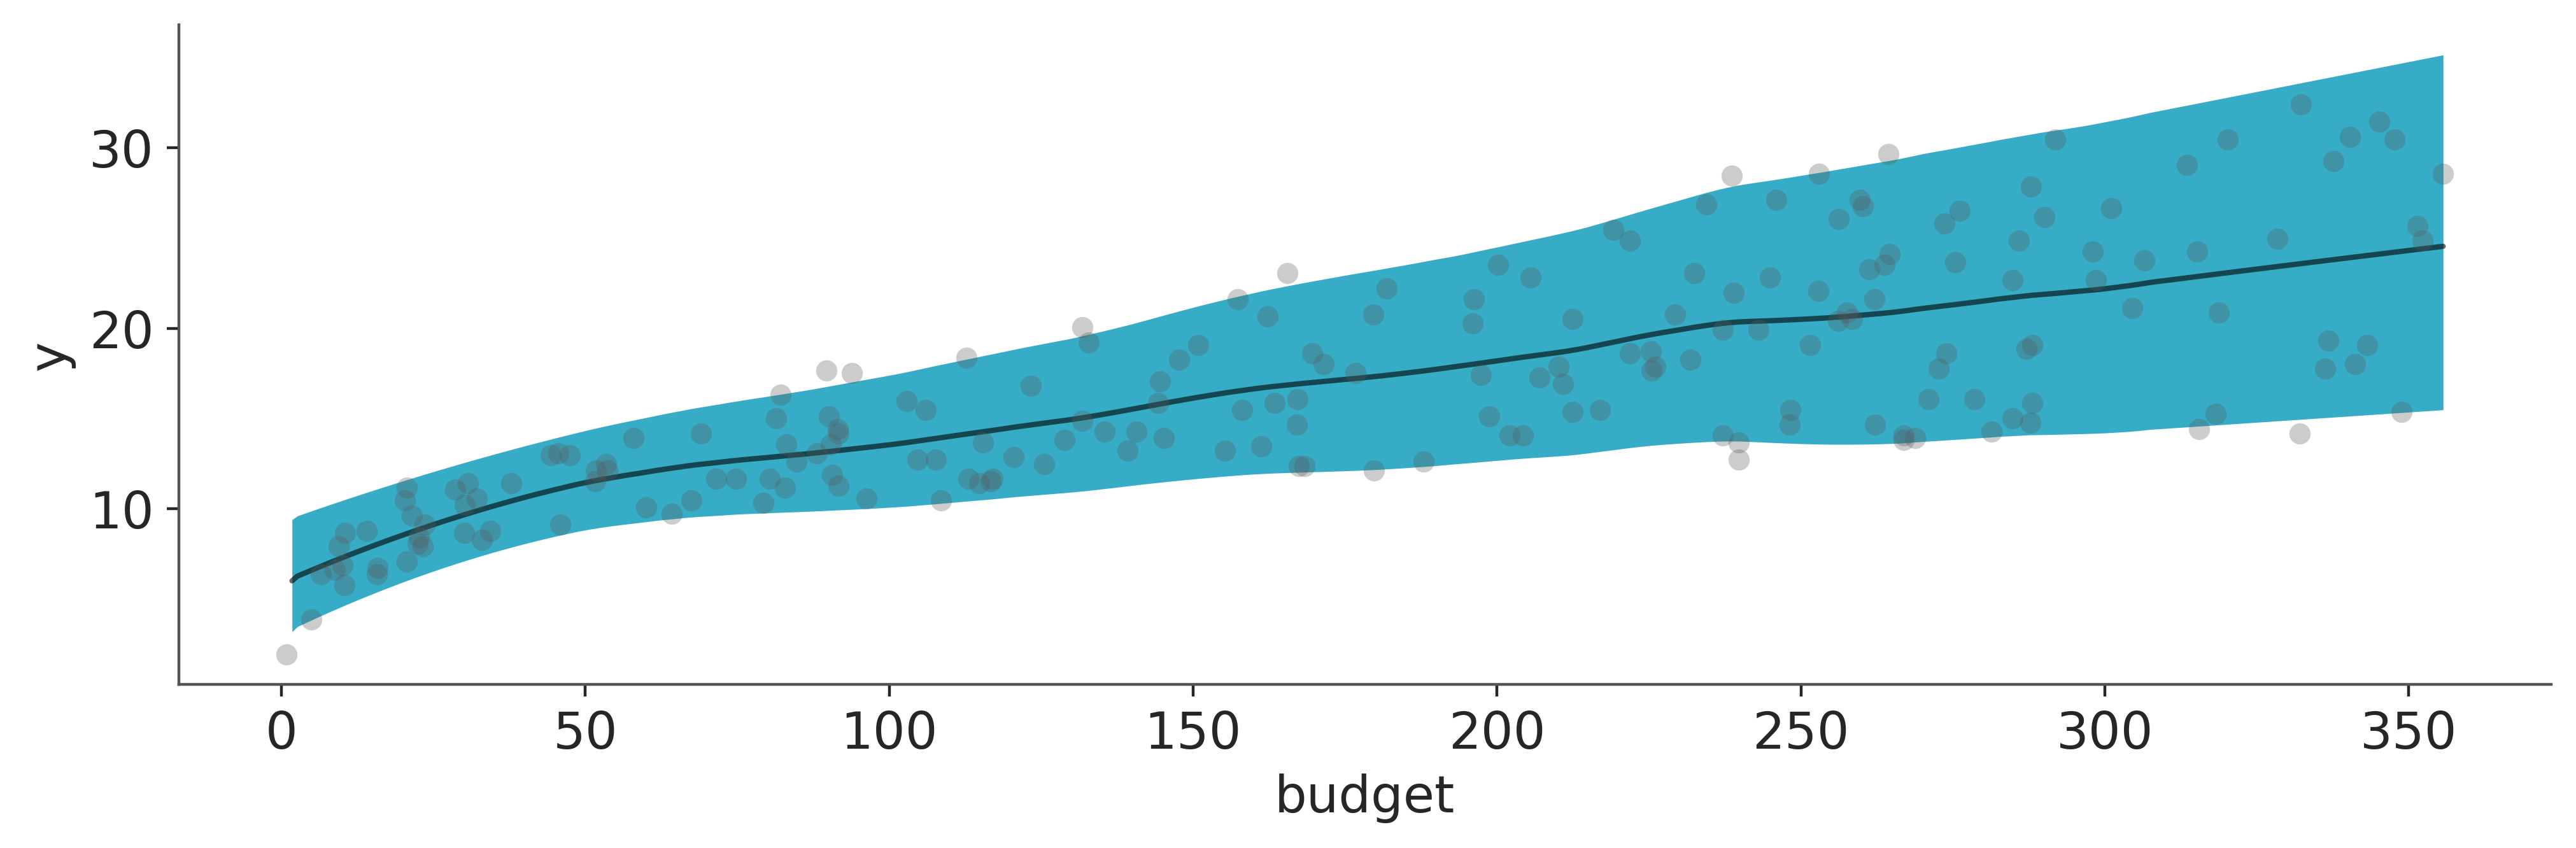

In [9]:
dt_plot = az.from_dict(
    {
        "posterior_predictive": {
            "y": posterior_predictive_marketing_full.posterior_predictive["y"]
        },
        "observed_data": {"y": df["sales"].values},
        "constant_data": {"budget": X[:, 0]},
    },
    dims={
        "y": ["budget_dim"],
        "budget": ["budget_dim"],
    },
)

az.plot_lm(dt_plot, x="budget", y="y");

The fit looks good! In fact, we see that the mean and variance increase as a function of the budget.

## Authors
- Authored by [Juan Orduz](https://juanitorduz.github.io/) in Feb, 2023 
- Rerun by Osvaldo Martin in Mar, 2023
- Rerun by Osvaldo Martin in Nov, 2023
- Rerun by Osvaldo Martin in Dec, 2024

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Dec 03 2025

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.3.0

pytensor: 2.35.1

pymc      : 5.26.1
numpy     : 2.2.6
arviz     : 0.23.0.dev0
matplotlib: 3.10.3
pandas    : 2.3.0
pymc_bart : 0.11.0

Watermark: 2.5.0



:::{include} ../page_footer.md
:::